# Lab 2: Constrained minimization

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import math as mt
from numpy import linalg as ln
import time

# I. Introduction: <a id='I'></a>

In this lab session, we present three different ways to numerically solve a convex, quadratic minimization problem with a single linear equality constraint:
$$
\text{minimize } f(x)= \frac{1}{2}x^TAx+b^Tx\text{ over all }x\in \mathbb{R}^N\text{ such that } c(x)=d^Tx-1=0,
$$
with $A$ symmetric positive definite, and $b,d\in \mathbb{R}^N$, with $d\neq 0$. 

**Question 1** Prove that there is a unique minimizer $x^*$. Write down the 1st order necessary condition for minimization.

**Solution 1**
$ f(x+h) = 1/2 (x+h).T A (x+h) + b.T (x+h) =  1/2 x.T A x + 1/2 x.T A h + 1/2 h.T A x + 1/2 h.T A h + b.T x + b.T h $
$        = f(x) + x.T A h +b.T h + 1/2 h.T A h = f(x) + <\nabla f(x), h> + 1/2 <h.T * Hf(x) , h> $

$ \nabla f(x) = Ax + b $   and $ Hf(x) = A $

A positive def definite so  f is $ \gamma - convex $

$ \nabla c(x) = d  $  since d is not null

so c is a regular      => it exist a unique minimizer $x^*$

First-order necessary (and sufficient) condition
there exists a unique in $\lambda \in \mathbb{R}$ such that 
$ \nabla f(x*) + \lambda \nabla c(x^*) = 0 =$
$ Ax^* + b + \lambda d = 0 $

**Question 2** Deduce that $x^*=-A^{-1}(b+\lambda d)$, with $\displaystyle \lambda=-\frac{1+d^TA^{-1}b}{d^TA^{-1}d}$. 

Write programs with input $x$ that return $f(x)$, gf$=\nabla f(x)$, $c(x)$ and gc$=\nabla c(x)$, and one that returns $x^*$ and the Lagrange multiplier $\lambda$ directly.

**Note:** We will consider the case the case $N=2$ to allow figures, but codes should be written to allow arbitrari matrix sizes. For the tests and figures, use
$$
A=\begin{pmatrix}2&-1\\-1&2\end{pmatrix},\ b=\begin{pmatrix}1\\3\end{pmatrix},\ d=\begin{pmatrix}1\\1\end{pmatrix}.
$$

**Solution 2**

$$ Ax^* + b + \lambda d = 0 $$

$$ x^* = -A^{-1}(b+\lambda d)$$

$$ d^Tx^*-1 = d^T (-A^{-1}(b+\lambda d)) - 1 = 0$$

$$ -d^T A^{-1} b - d^T A^{-1} \lambda d - 1 = 0 $$

$$ d^T A^{-1} \lambda d = -d^T A^{-1} b - 1 $$

$$ \lambda=-\frac{1+d^TA^{-1}b}{d^TA^{-1}d} $$

In [21]:
A=np.array([[2,-1],[-1,2]])
b=np.array([1,3])
d=np.array([1,1])

In [22]:
##Solution 2: fill in the BLANKs
def objective(x):
    return np.sum(x*(0.5*A@x+b))

def gradobj(x):
    return np.sum(0.5*A@x + b)

def constraints(x):
    return np.sum(d*x)-1

def gradconstraints(x):
    return np.sum(x)

def OptimSetup(x):
    f=objective(x)
    gf=gradobj(x)
    c=constraints(x)
    gc=gradconstraints(x)
    return (f,gf,c,gc)

def exactmin(A,b,d):
    Amd= np.linalg.solve(A,d)
    lamb=-(1.+np.sum(b*Amd))/np.sum(d*Amd)
    solution=-np.linalg.solve(A,b+lamb*d)
    y= objective(solution)
    cons=constraints(solution)
    return (solution,lamb,y,cons)

**Question 3** Compute $x^*, \lambda$ and $y^*=f(x^*)$ in this case. Then, using code from the previous session, level sets of $f$ around $x^*$ (including that at value $y^*$), and the set defined by the constraints (1-level set of c) have all been drawn. 

Geometrically, what do you notice?

In [23]:
sol,lamb,minf,cons=exactmin(A,b,d)
print(sol,lamb,minf,cons)

[0.83333333 0.16666667] -2.5 1.9166666666666667 0.0


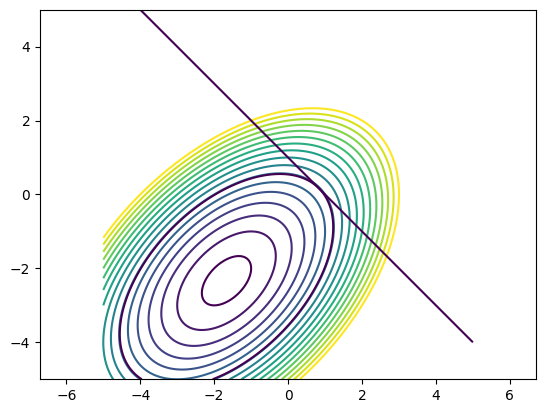

In [24]:
import matplotlib.pyplot as plt 

def level_lines(f, xmin, xmax, ymin, ymax, levels, N=500):
    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)
    z = f(*np.meshgrid(x, y))
    level_l = plt.contour(x, y, z, levels=levels)

f = lambda x, y: 0.5*(2*x**2-2*x*y+2*y**2)+x+3*y
c = lambda x, y: x+y-1

level_lines(f, -5, 5, -5, 5, np.linspace(-4, 12, 17))
level_lines(f, -5, 5, -5, 5, np.linspace(minf, minf, 1))
level_lines(c, -5, 5, -5, 5, np.linspace(0, 0, 1))

plt.axis('equal')
plt.show()

**Solution 3**:
 we see the constraint c is tangent to the level line minf

# I. Penalization: <a id='I'></a>

This method consists in replacing the constrained minimization by an unconstrained, penalized minimization problem as follows:
$$
\text{Minimize } f_\rho(x)=f(x)+\rho \Vert c(x)\Vert^2\text{ over all }x\in \mathbb{R^N}.
$$
Here, we take $\rho$ to be a large positive number. Notice that for linear constraints, $f$ convex implies $f_\rho$ convex.

In our case,
$$
f_\rho(x)=\frac{1}{2}x^TAx+b^Tx+\rho(d^Tx-1)^2.
$$

**Question 4** Show that 
$$
\nabla f_\rho(x)=\nabla f(x)+2\rho c(x)\nabla c(x)=(A+2\rho dd^T)x+b-2\rho d,
$$
and compute the minimizer $x^*_\rho$ of $f_\rho$.

**Solution 4**
$$ \nabla f_p(x) = Ax + b + 2\rho (d.Tx - 1)d $$
$$      = \nabla f(x)+2\rho c(x)\nabla c(x) $$
$$               =  Ax + b + 2\rho d.Txd - 2*\rho d  $$
$$               = (A +  2\rho dd.T)x + b - 2\rho d $$

$ \nabla f_p(x_{\rho}*) = 0 $ => $ x_{\rho}* = (A +  2\rho dd^T)^{-1} (2\rho d - b) $

**Question 5** Code functions that compute, for any given $x$, the values of $f(x)$, $\nabla f_\rho(x)$ and $x_\rho^*$. Verify numerically that $x_\rho^*\rightarrow x^*$ as $\rho$ goes to infinity.

In [25]:
#Solution 5
#Tip :  dd^T can be coded as        np.matmul(d[:,np.newaxis],d[np.newaxis,:])
rho=10

def objpen(x):
    return objective(x)+rho*(constraints(x)**2)

def gradobjpen(x):
    return gradobj(x)+2*rho*constraints(x)*gradconstraints(x)

def minpen(A,b,d,rho):
    M =  A + 2*rho*np.matmul(d[:,np.newaxis],d[np.newaxis,:])
    xrho = np.linalg.solve(M,2*rho*d - b)
    return xrho

In [26]:
##verify that as rho goes to infinity, xrho goes to the solution
rho= 1000
xrho=minpen(A,b,d,rho)
print(xrho,sol)

[0.83270849 0.16604182] [0.83333333 0.16666667]


**Question 5** Write a code that uses gradient descent with a basic linesearch to minimize $f_\rho$ in 1000 steps (forego the usual stopping criterion). 

Test it for $\rho=1,10,100,1000$, drawing the trajectory of the sequence over the level sets of $f$.

In [27]:
## Solution 5: Fill in the BLANKS
def optim(f, gradf, beta, gamma, x0, N): # beta and gamma are the linesearch parameters
    xi = x0
    X=[np.copy(x0)]
    for i in range(N):
        alpha = 1
        d = -gradf(xi)
        j=0
        while f(xi + alpha * d) > f(xi) + gamma * alpha * np.sum(d* gradf(xi)) and j<20: #linesearch
            j=j+1
            alpha = beta * alpha
        xi = xi + alpha * d
        X.append(np.copy(xi))
    return np.array(X)

C:\Users\salio\AppData\Local\Temp\ipykernel_34660\2395333392.py:3: RuntimeWarning: overflow encountered in multiply
  return np.sum(x*(0.5*A@x+b))
C:\Users\salio\AppData\Local\Temp\ipykernel_34660\2047029100.py:6: RuntimeWarning: overflow encountered in scalar power
  return objective(x)+rho*(constraints(x)**2)
C:\Users\salio\AppData\Local\Temp\ipykernel_34660\1223875229.py:9: RuntimeWarning: overflow encountered in scalar multiply
  while f(xi + alpha * d) > f(xi) + gamma * alpha * np.sum(d* gradf(xi)) and j<20: #linesearch
C:\Users\salio\AppData\Local\Temp\ipykernel_34660\2395333392.py:3: RuntimeWarning: invalid value encountered in matmul
  return np.sum(x*(0.5*A@x+b))
C:\Users\salio\AppData\Local\Temp\ipykernel_34660\1223875229.py:9: RuntimeWarning: invalid value encountered in scalar add
  while f(xi + alpha * d) > f(xi) + gamma * alpha * np.sum(d* gradf(xi)) and j<20: #linesearch
C:\Users\salio\AppData\Local\Temp\ipykernel_34660\2395333392.py:6: RuntimeWarning: invalid value enco

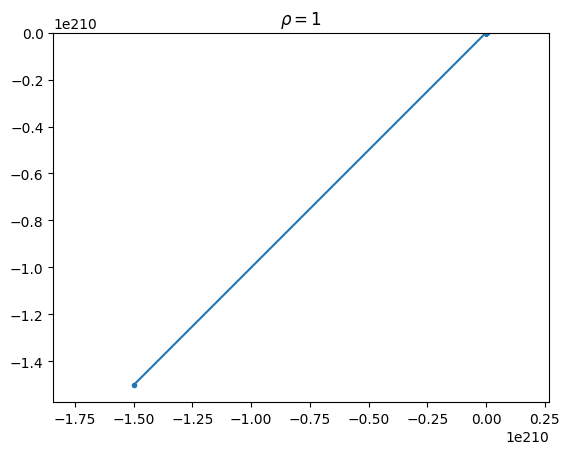

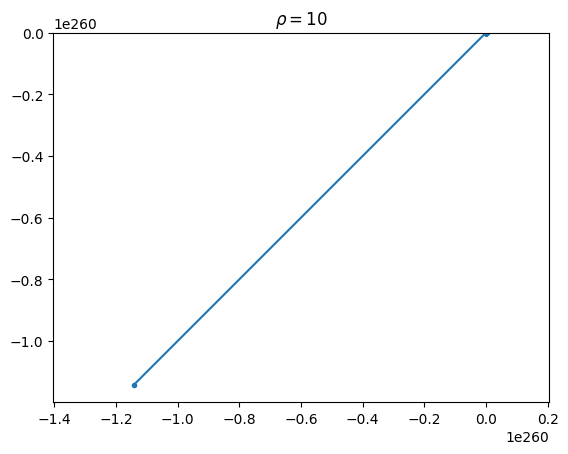

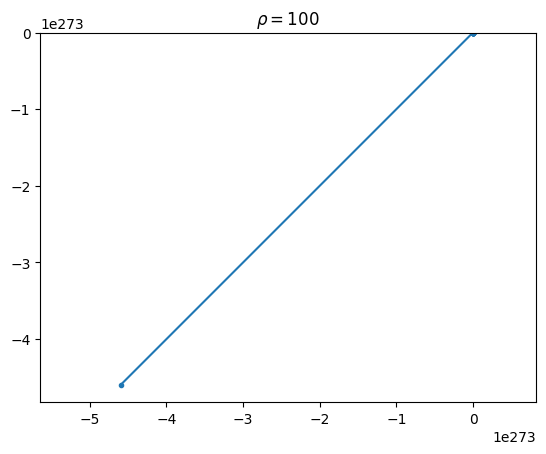

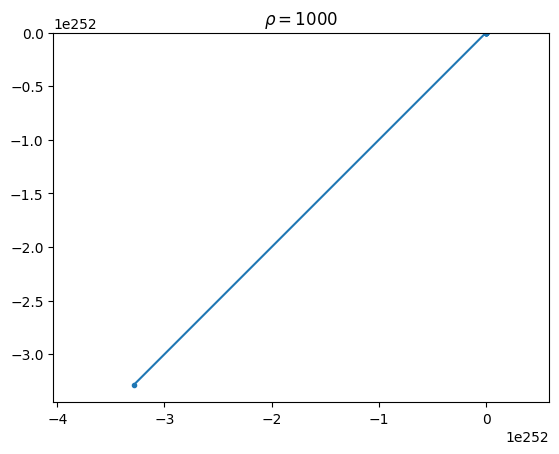

In [32]:
x0=np.array([0,0])
beta=0.75
gamma=0.5
N=1000

##plotting results for rho=1,10...
for i in range(4):
    rho=10**i
    Xrho=optim(objpen, gradobjpen, beta, gamma, x0, N)
    plt.figure()
    plt.title(fr"$\rho=${rho}")
    f = lambda x, y: 0.5*(2*x**2-2*x*y+2*y**2)+x+3*y
    c = lambda x, y: x+y-1
    level_lines(f, -3, 3, -3, 3, np.linspace(-4, 12, 17))
    level_lines(f, -3, 3, -3, 3, np.linspace(1.9166666666666667, 1.9166666666666667, 1))
    level_lines(c, -3, 4, -3, 3, np.linspace(0, 0, 1))
    plt.plot(Xrho[:,0],Xrho[:,1],'.',linestyle='-')
    plt.axis('equal')

**Question 6** Draw the level sets of $f_\rho$ for $\rho=1,10,100$. Comment.

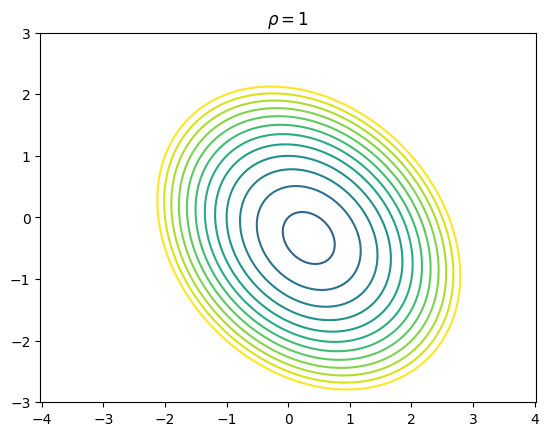

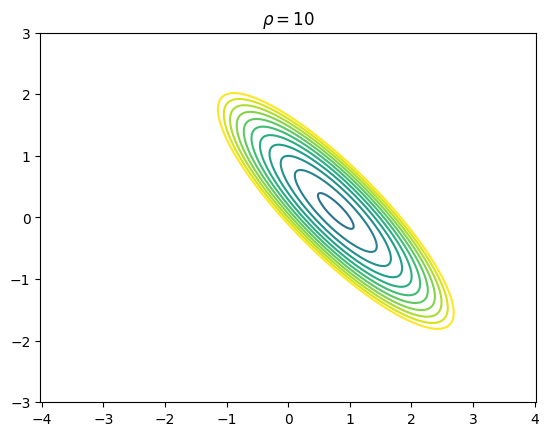

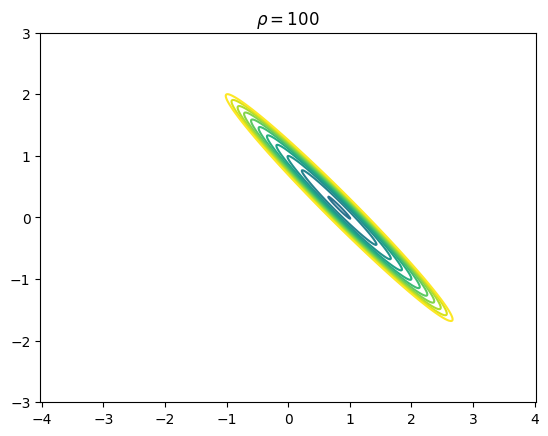

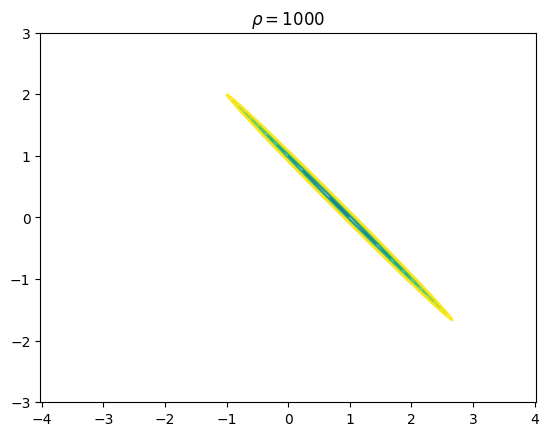

In [33]:
##Solution 6
for i in range(4):
    plt.figure()
    rho=10**i
    f = lambda x, y: 0.5*(2*x**2-2*x*y+2*y**2)+x+3*y+rho*(x+y-1)**2
    level_lines(f, -3, 3, -3, 3, np.linspace(-4, 12, 17))
    plt.axis('equal')
    plt.title(fr"$\rho=${rho}")
    plt.show()
    time.sleep(0.1)

**Solution 6**

we remark when \rho increase, the level sets of $f_\rho$ become increasingly elongated in the direction orthogonal to the constraint.

# II. Projected Gradient: <a id='I'></a>

**Question 7 (Bonus)** Let $C$ be a convex set subset of $\mathbb{R}^N$. Prove that for any $x\in\mathbb{R}^N$, there is a unique point $P_C(x)\in C$ such that for any $y\in C$, $\Vert x -P_C(x)\Vert\leq \Vert x-y\Vert$. In other words, $P_C(x)$ is the projection of $x$ onto $C$. 

When $C$ is an affine subspace, $P_C(x)$ is just the orthogonal projection onto $C$.

**Solution 7**

Let $ C \subset \mathbb{R}^N $ be a nonempty closed convex set and $ x \in \mathbb{R}^N $.
Define
$
\varphi(y)=\|x-y\|^2 ,\quad y\in C.
$
The function $ \varphi $ is continuous and strictly convex. Since $ C $ is closed,
$ \varphi $ attains a minimum on $ C $; denote the minimizer by $ P_C(x) $.

If two distinct minimizers existed, their midpoint would belong to $ C $ by convexity,
and strict convexity of $ \varphi $ would give a smaller value, a contradiction.
Hence the minimizer is unique.

If $ C $ is an affine subspace, the optimality condition implies that
$ x-P_C(x) $ is orthogonal to $ C $, so $ P_C(x) $ is the orthogonal projection.



The Projected Gradient method consists in starting from a point $x_0$ in the constrained set $C$ and, at each step, applying the unconstrained gradient descent, followed by the projection of the descended point obtained back to the constrained set. So, for $k=0,1,2,\ldots\ $ up to convergence, repeat:

$$
\left|
\begin{array}{lcl}
v^k& \longleftarrow & -\nabla f(x^k),\\
\alpha^k &\longleftarrow &\text{Line-search}\ \left(\ t\mapsto f(P_c(x^k + tv^k))\ \right),\\ 
x^{k+1}&\longleftarrow &P_c(x^k+\alpha^k v^k)
\end{array}
\right.
$$
where $P_C$ is the projection operator onto the set of constraints $C=\{x,\ c(x)=0\}$ defined in Question 7. 

In this case, the linesearch step needs to be adjusted: instead of asking for 
$$
f(x^k + tv^k)<f(x^k)-t\gamma \nabla f(x^k)^Tv^k,
$$ 
we replace $v^k$ with $P(x^k+tv^k)-x^k$, so the condition becomes  
$$
f(P_C(x^k + tv^k))<f(x^k)-t\gamma \nabla f(x^k)^T(P_C(x^k+tv^k)-x^k)).
$$

**Example**: For a constraint like $C=\{(0,x_2)\in \mathbb{R}^2\}$, $P_C(x_1,x_2)=(0,x_2)$, so the algorithm becomes

$$
\left|
\begin{array}{lcl}
v^k=\begin{pmatrix}v^k_1\\v^k_2\end{pmatrix}& \longleftarrow & -\nabla f(x^k),\\
\alpha^k &\longleftarrow &\text{Line-search}\ \left(\ t\mapsto f(P_c(x^k + tv^k))=\ f\begin{pmatrix}0\\x^k_2+tv^k_2\end{pmatrix}\right),\\ 
x^{k+1}&\longleftarrow &\begin{pmatrix}0\\x^k_2+\alpha^kv^k_2\end{pmatrix}
\end{array}
\right.
$$

**Question 8** In our case, prove that $\displaystyle P_C(x)=x-\frac{d^Tx-1}{\Vert d\Vert^2}d$. 

Code the projection function $P_C(x)$ and test it on some points.

**Solution 8** 

The constraint set is $ C=\{x\in\mathbb{R}^N \mid d^T x=1\} $, an affine hyperplane with normal vector $ d $.

The projection of $ x $ onto $ C $ must therefore be of the form $ x-\alpha d $.

Imposing the constraint,
$
d^T(x-\alpha d)=1 \quad\Rightarrow\quad 
\alpha=\frac{d^T x-1}{\|d\|^2}.
$

Hence,
$
P_C(x)=x-\frac{d^T x-1}{\|d\|^2}d.
$


In [34]:
#Solution 8 fill in the BLANK
def proj(x):
    diff = ((d@x -1)*d)/ np.linalg.norm(d)**2
    return x - diff

In [35]:
x0=np.array([0,0]) 
x1=np.array([1,2])
x2=np.array([0.5,0.5])
y0=proj(x0)
y1=proj(x1)
y2=proj(x2)
print(constraints(y0),constraints(y1),constraints(y2))

-2.220446049250313e-16 4.440892098500626e-16 0.0


**Question 9** Write the projected gradient algorithm and test it for $N=10$ steps. Draw the sequence $(x_0,x_1,...)$ on a figure along with level sets of $f$ and the constraints set. 

In [36]:
#Solution 9
#tip: don't forget to ensure x0 belong to C (p is the projection function )
#
def optimproj(f, gradf, p, beta, gamma, x0, N, niter_ls_max): # beta and gamma are the linesearch parameters
    X=[np.copy(x0)]
    xi = p(x0)
    X.append(np.copy(xi))
    for i in range(N):
        alpha = 1
        d = -gradf(xi)
        j=0
        xtest = xi
        while j<20 and f(xtest) > f(xi) + gamma * alpha * np.sum((xtest-xi)* gradf(xi)):
            j=j+1
            alpha = beta * alpha
            xtest= p(xi + alpha * d)
        xi = xtest
        X.append(np.copy(xi))
    return np.array(X)


(np.float64(-3.0), np.float64(4.0), np.float64(-3.0), np.float64(3.0))

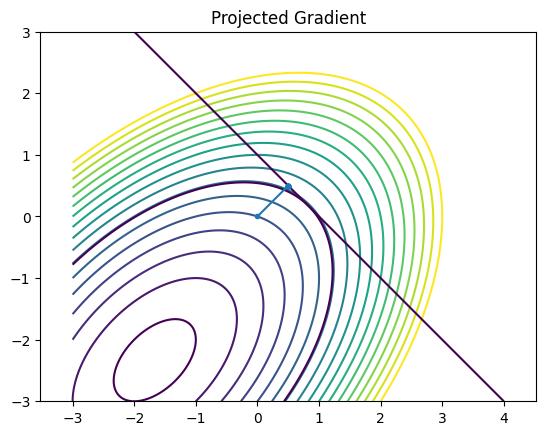

In [37]:
x0=np.array([0,0])
beta=0.75
gamma=0.5
N=10
niter_ls_max=20
X=optimproj(objective, gradobj, proj, beta, gamma, x0, N, niter_ls_max)
plt.figure()
plt.title(fr"Projected Gradient")
f = lambda x, y: 0.5*(2*x**2-2*x*y+2*y**2)+x+3*y
c = lambda x, y: x+y-1
level_lines(f, -3, 3, -3, 3, np.linspace(-4, 12, 17))
level_lines(f, -3, 3, -3, 3, np.linspace(1.9166666666666667, 1.9166666666666667, 1))
level_lines(c, -3, 4, -3, 3, np.linspace(0, 0, 1))
plt.plot(X[:,0],X[:,1],'.',linestyle='-')
plt.axis('equal')

**Question 10** Can you think of circumstances where this method could be too computationnally intensive to be useful?

**Solution 10**
Projected gradient can be expensive when:

1. Constraint set is complex (non-affine)

2. Each iteration requires solving a large system

# III. Duality-based Lagrangian method: Uzawa update <a id='I'></a>

This method is based on a result from class (to be seen next time). Define the Lagrangian
$$
\mathcal{L}(x,\lambda)=f(x)+\lambda c(x),\ x\in \mathbb{R}^N,\ \lambda\in \mathbb{R}.
$$
Note that for $x\in C=\{x,\ c(x)=0\}$, $\mathcal{L}(x,\lambda)=f(x)$ for every $\lambda$.

**Question 11** Let $(x^*,\lambda^*)\in \mathbb{R}^N\times\mathbb{R}$ be the constrained minimizer and corresponding lagrange mutliplier:
$$
\nabla f(x^*)+\lambda^*\nabla c(x^*)=0.
$$
Prove that $\nabla\mathcal{L}(x^*,\lambda^*)=0$.

**Solution 11** 
 $$\nabla_{x}\mathcal{L}(x^*,\lambda^*) = \nabla f(x^*)+\lambda^*\nabla c(x^*) = 0$$

 $$ \nabla_{\lambda}\mathcal{L}(x^*,\lambda^*) = c(x^*) = 0$$

 Hence :

 $$\nabla\mathcal{L}(x^*,\lambda^*)=0$$

Let $(x^*,\lambda^*)\in \mathbb{R}^N\times\mathbb{R}$ the constrained minimizer and corresponding lagrange mutliplier

**Theorem:** For a convex functions and affine constraints,
$$
f(x^*)=\max_{\lambda\in \mathbb{R}}\min_{x\in \mathbb{R}^N} \mathcal{L}(x,\lambda)=\mathcal{L}(x^*,\lambda^*).
$$

This leads to an alternating method in which, at each step, we descend in $x$ then ascend in $\lambda$: start with initial guesses $(x_0,\lambda_0)$ for the Lagrange multiplier, then for $k=0,1,2,\dots$, define

$$
\left|
\begin{array}{lcl}
v^k& \longleftarrow & -\nabla_x \mathcal{L}(x^k,\lambda^k),\\
\mu^k& \longleftarrow& \ \nabla_\lambda\mathcal{L}(x^k,\lambda^k),\\
\alpha^k &\longleftarrow &\text{Line-search}\ \left(\ t\mapsto \mathcal{L}(x^k + tv^k,\lambda^k)\ \right),\\ 
x^{k+1}&\longleftarrow &x^k+\alpha^k v^k,\\
\lambda^{k+1}&\longleftarrow &\lambda^k+s^0\mu^k
\end{array}
\right.
$$

**Remark:** $\nabla_\lambda\mathcal{L}(x,\lambda)=c(x).$

**Question 12** For fixed $x$, what is the nature of $\lambda\mapsto \mathcal{L}(x,\lambda)$. Deduce that we can't perform a line-search for the step length of the update of the Lagrange multiplier.

**Solution 12**
For fixed x,

 $$\mathcal{L}(x,\lambda) = f(x)+\lambda c(x)$$ is linear in $ \lambda$
 
 So no min or max then no line search possible

**Question 13** Write a code that performs this algorithm for a given number $N$ of steps and $s_0$. Let it run on our problem for $N=100$ and $s=0.1$, $x_0=0$ and $\lambda_0=0$. Draw the result on a figure that includes level sets of $f$ and the constraints. 

In [38]:
##Solution 13
def lagrangian(x,lam):
    return objective(x) + lam * constraints(x)

def gradlagx(x,lam):
    return gradobj(x) + lam * d

def gradlaglam(x,lam):
    return constraints(x)

def optimlag(lag,gradx,gradlam,beta,gamma,x0,lam0,s0, N):
    xi = x0
    X=[x0]
    lami=lam0
    for i in range(N):
        alpha = 1
        d = -gradlagx(xi,lami)
        mu= gradlaglam(xi,lami)
        xtest= xi + alpha*d
        j=0
        while lag(xtest,lami) > lag(xi,lami) + gamma * alpha * np.sum((xtest-xi)* gradlagx(xi,lami)) and j<20:
            alpha = beta * alpha
            xtest= xi + alpha*d
        xi = xtest
        lami = lami + s0*mu
        X.append(xi)
    lamn=lami
    return (np.array(X),lamn)
    


(np.float64(-3.0), np.float64(3.0), np.float64(-3.0), np.float64(3.0))

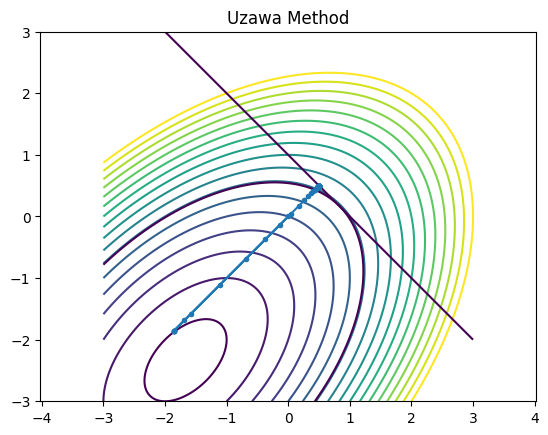

In [39]:
beta=0.75
alpha=0.5
lam0=0
x0=np.array([0,0])
s0=0.1
N=100
X,lam = optimlag(lagrangian,gradlagx,gradlaglam,beta,gamma,x0,lam0,s0, N)
plt.figure()
plt.title(fr"Uzawa Method")
f = lambda x, y: 0.5*(2*x**2-2*x*y+2*y**2)+x+3*y
c = lambda x, y: x+y-1
level_lines(f, -3, 3, -3, 3, np.linspace(-4, 12, 17))
level_lines(f, -3, 3, -3, 3, np.linspace(1.9166666666666667, 1.9166666666666667, 1))
level_lines(c, -3, 3, -3, 3, np.linspace(0, 0, 1))
plt.plot(X[:,0],X[:,1],'.',linestyle='-')
plt.axis('equal')

In [40]:
print(X[-1],lam)
print(sol,lamb)

[0.5 0.5] -4.499999999999856
[0.83333333 0.16666667] -2.5


**Question 15** Try the algorithm with $s=1$ and $s_0=0.001$. Discuss.

(np.float64(-13.0), np.float64(8.0), np.float64(-13.0), np.float64(3.0))

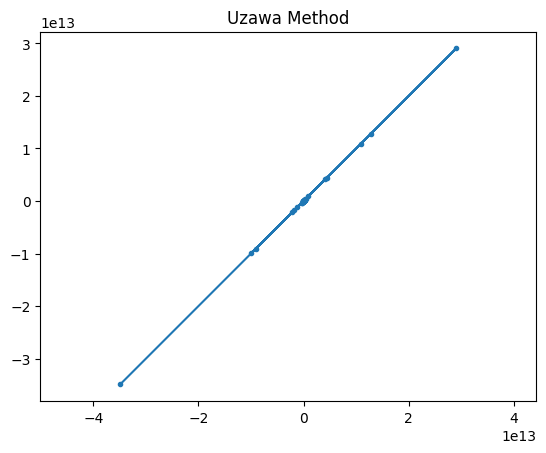

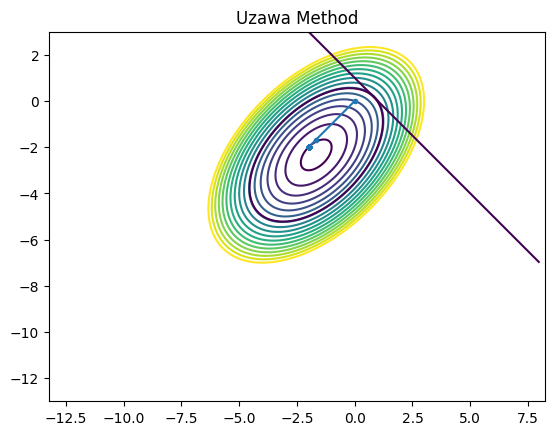

In [47]:
lam0=0
x0=np.array([0,0])
s0=1
N=100
X,lam = optimlag(lagrangian,gradlagx,gradlaglam,beta,gamma,x0,lam0,s0, N)
plt.figure()
plt.title(fr"Uzawa Method")
f = lambda x, y: 0.5*(2*x**2-2*x*y+2*y**2)+x+3*y
c = lambda x, y: x+y-1
level_lines(f, -13, 3, -13, 3, np.linspace(-4, 12, 17))
level_lines(f, -13, 3, -13, 3, np.linspace(1.9166666666666667, 1.9166666666666667, 1))
level_lines(c, -13, 8, -13, 3, np.linspace(0, 0, 1))
plt.plot(X[:,0],X[:,1],'.',linestyle='-')
plt.axis('equal')

s0=0.001
N=100
X,lam = optimlag(lagrangian,gradlagx,gradlaglam,beta,gamma,x0,lam0,s0, N)
plt.figure()
plt.title(fr"Uzawa Method")
f = lambda x, y: 0.5*(2*x**2-2*x*y+2*y**2)+x+3*y
c = lambda x, y: x+y-1
level_lines(f, -13, 3, -13, 3, np.linspace(-4, 12, 17))
level_lines(f, -13, 3, -13, 3, np.linspace(1.9166666666666667, 1.9166666666666667, 1))
level_lines(c, -13, 8, -13, 3, np.linspace(0, 0, 1))
plt.plot(X[:,0],X[:,1],'.',linestyle='-')
plt.axis('equal')

**Solution 15**

- For $s_0 = 1$: too large, the method oscillates and may diverge.  
- For $s_0 = 0.001$: too small, the method is stable but converges very slowly.  

**Conclusion:** Step size must be chosen carefully for Uzawa to work efficiently.


**Question 16** Discuss each method's pros and cons, and which do you believe to be the best, both in general and for this specific minimization problem.

**Solution 16**

| Method | Pros | Cons |
|--------|------|------|
| Exact solution | Direct computation of \(x^*\) and \(\lambda^*\); very fast for small problems | Requires solving a linear system; not scalable to large \(N\) |
| Penalization | Simple to implement; unconstrained optimization | Large \(\rho\) makes problem ill-conditioned; slow convergence if \(\rho\) is small |
| Projected gradient | Maintains feasibility at each step; conceptually simple | Projection can be costly for complex constraints; may converge slowly |
| Uzawa (Lagrangian) | Alternates primal/dual updates; handles constraints explicitly | Sensitive to step size \(s_0\); may oscillate or converge slowly |

**Best choice:** The exact solution, since the problem is small, quadratic, and the constraint is linear.  
For larger-scale or more complex constraints, Uzawa or projected gradient methods may be preferable.

